## Our Problem Statement: ML-Driven Estimation of Last Price Valuation in Options Trading

When implemented correctly we can predict the price the option would close at when it expires, allowing a trader to come up with a safe stratergy to always exit the option when it is profitable. 

Theoretically compounding gains given everything else remains constant.

Importing the Dataset from Checkpoint 2 and filtering out data where C_LAST is 0:

In [12]:
import pandas as pd

# Load your dataset
data = pd.read_csv('/Users/pranav/Desktop/SU/AML_Project/filtered_dataset.csv')

# Filter out rows where 'C_LAST' is zero
filtered_data = data[data['C_LAST'] != 0]

# Save the filtered dataset if necessary
filtered_data.to_csv('/Users/pranav/Desktop/SU/AML_Project/final_filtered_data.csv', index=False)

# Display the shape of the original and filtered datasets to compare
print(f"Original Dataset Shape: {data.shape}")
print(f"Filtered Dataset Shape: {filtered_data.shape}")

Original Dataset Shape: (37110, 16)
Filtered Dataset Shape: (25424, 16)


Adding another column for VIX, which is the volatility index

In [13]:
import yfinance as yf

# Define your start and end date based on your dataset's period
start_date = filtered_data['QUOTE_DATE'].min()
end_date = filtered_data['QUOTE_DATE'].max()

# Fetch VIX data using yfinance
vix = yf.Ticker("^VIX")
hist = vix.history(start=start_date, end=end_date)

# The 'Close' column in 'hist_vix' represents the closing price of VIX
# Rename 'Close' to 'VIX' for clarity
hist.rename(columns={'Close': 'VIX'}, inplace=True)

# Reset the index to make the 'Date' column usable for merging
hist = hist.reset_index()

# Convert the 'Date' column in the fetched VIX data to be timezone-naive
hist['Date'] = hist['Date'].dt.tz_localize(None)

# Assuming 'df' is your original DataFrame that includes the '[QUOTE_DATE]' column
# First, ensure that '[QUOTE_DATE]' is of datetime type and has the same format as the VIX data 'Date' column
filtered_data['QUOTE_DATE'] = pd.to_datetime(filtered_data['QUOTE_DATE'])

# Merge the VIX data into your original DataFrame
# We're merging on the '[QUOTE_DATE]' column from your DataFrame and the 'Date' column from the fetched VIX data
df_merged = pd.merge(filtered_data, hist[['Date', 'VIX']], left_on='QUOTE_DATE', right_on='Date', how='left')

# Drop the extra 'Date' column if it's redundant
df_merged.drop(columns=['Date'], inplace=True)

# Now your df_merged should contain the VIX values corresponding to your '[QUOTE_DATE]' dates

/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_3677/957551053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['QUOTE_DATE'] = pd.to_datetime(filtered_data['QUOTE_DATE'])


Checking for nulls

In [14]:
df_merged.isnull().sum()

Spot_Price         0
STRIKE             0
DTE                0
DTB3               0
C_IV               0
C_DELTA            0
C_GAMMA            0
C_VEGA             0
C_THETA            0
C_RHO              0
C_LAST             0
C_BID              0
C_ASK              0
QUOTE_DATE         0
EXPIRE_DATE        0
BS_Call_Price      0
VIX              112
dtype: int64

Removing rows with nulls

In [15]:
df = df_merged.dropna(subset=['VIX'])

In [16]:
df.isnull().sum()

Spot_Price       0
STRIKE           0
DTE              0
DTB3             0
C_IV             0
C_DELTA          0
C_GAMMA          0
C_VEGA           0
C_THETA          0
C_RHO            0
C_LAST           0
C_BID            0
C_ASK            0
QUOTE_DATE       0
EXPIRE_DATE      0
BS_Call_Price    0
VIX              0
dtype: int64

Plotting histograms to identify skewed distributions

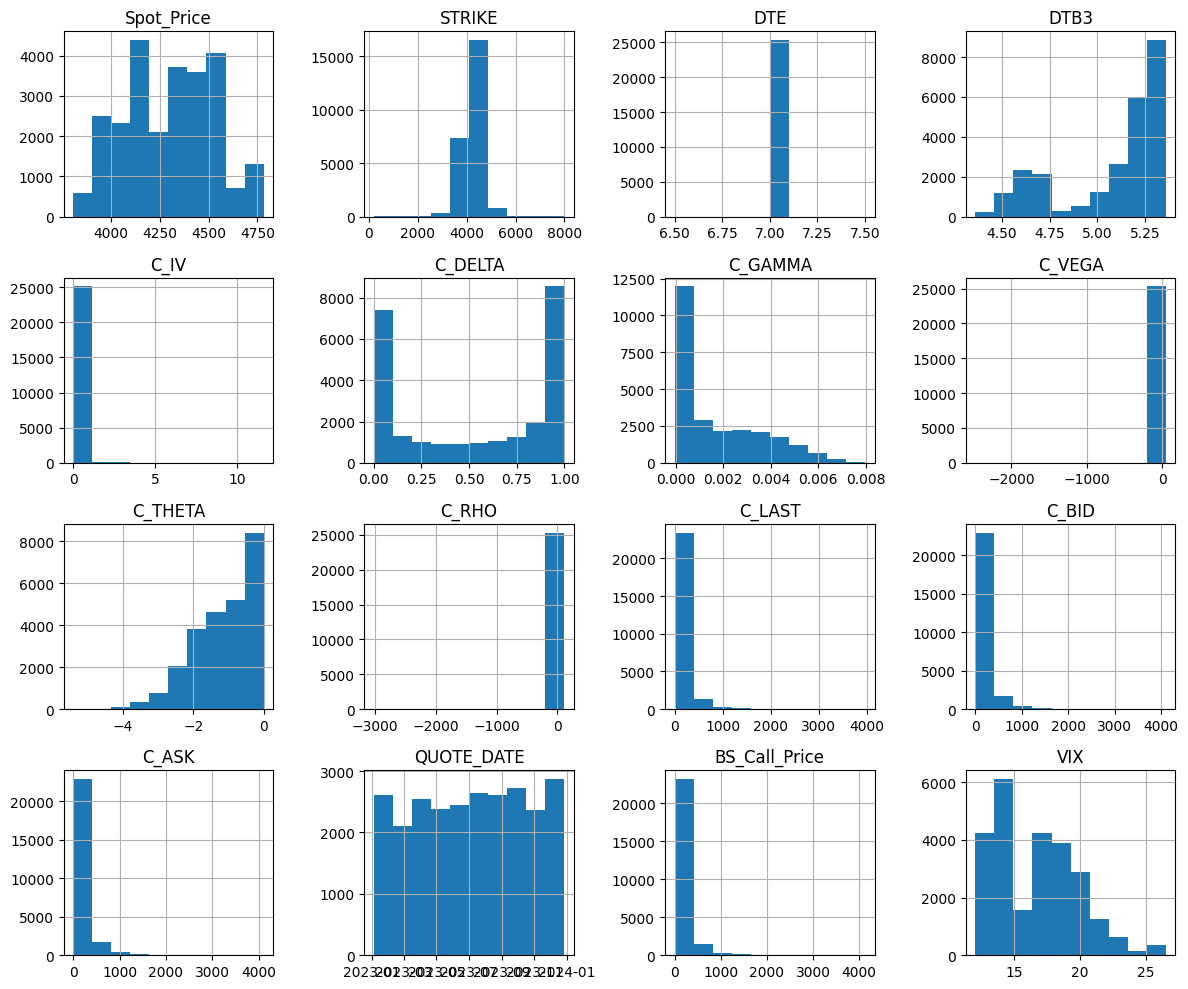

In [17]:
import matplotlib.pyplot as plt
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

These histograms provide a distribution overview of different financial metrics associated with options trading. Here’s an interpretation for each graph:

1. Spot_Price: The distribution is left-skewed, indicating that lower spot prices are more frequent in the dataset than higher prices. Most data points fall below 4500.

2. STRIKE: This histogram shows a bimodal distribution with two peaks, suggesting two common strike price levels around which options contracts are concentrated.

3. DTE (Days to Expiration): The histogram is right-skewed with most options having a short time to expiration, around 6 to 7 days, and fewer options with longer times to expiration.

4. DTB3 (Days to Barrier 3?): Appears to have a right-skewed distribution, implying most of the data is clustered around shorter DTB3, with a long tail extending towards higher values.

5. C_IV (Call Implied Volatility): Shows a very right-skewed distribution, indicating that lower implied volatility rates are more common than higher rates in this set of options.

6. C_DELTA: This metric has a multimodal distribution, with significant groupings around 0.25, 0.50, and 0.75, which are common Delta values for options (representing ITM, ATM, and OTM options).

7. C_GAMMA: The distribution is heavily right-skewed with most Gamma values concentrated close to zero, typical for options that are not near expiration or at-the-money.

8. C_VEGA: Vega values are negatively skewed, suggesting options with lower Vega are more common, and there are few options with high sensitivity to volatility.

9. C_THETA: Shows a left-skewed distribution, indicating that more options have a higher rate of time decay, which increases as options approach their expiration date.

10. C_RHO: RHO values are predominantly close to zero with a sharp drop-off, suggesting many options have minimal sensitivity to interest rate changes.

11. C_ASK: The distribution is right-skewed, indicating lower ask prices are more common, with a long tail towards higher prices suggesting fewer options have high ask prices.

12. C_LAST: The histogram indicates a distribution of the last traded price, with most options traded at lower prices, indicative of a right-skewed distribution.

13. C_BID: Similar to C_ASK, the distribution of bid prices is right-skewed, with most data concentrated at lower bid prices.

14. QUOTE_DATE: The histogram appears to show a uniform distribution across recent dates, indicating a balanced number of observations (option quotes) across different days.

15. BS_Call_Price (Black-Scholes Call Price)*: The distribution of model-calculated call prices shows a unimodal, somewhat symmetric distribution centered around a specific price level.

16. VIX: The distribution of VIX values is right-skewed, with most observations showing lower volatility index values, and a tail stretching towards higher values.

Each histogram provides insights into the properties of option contracts during the period in question. Skewed distributions in several metrics suggest that there's a heavier concentration of certain values over others, which could reflect market conditions or the nature of the options being traded.

## Let's talk about our final dataset:
- Where - optionsdx a reputable source for niche data among the internet community
- The data was for the year of 2023 and the ticker was SPX , the S&P 500 index.
- Why - we chose SPX because we wanted a primary estimator called blackscholes which works on european markets only! and SPX trades like the european markets.
- We added risk free rate, spot price, calculated theoritical price estimation column for black scholes and VIX (U.S market Volatitlity index)
- Our final workable dataset had dimensions of (25424,16).

# Experiments

The below code cell is performing several steps common to machine learning tasks, specifically regression analysis. Here's a breakdown of what's happening:

1. Import Libraries: It imports necessary Python libraries for data handling (pandas, numpy), machine learning model selection and evaluation (sklearn), and specific regression algorithms (RandomForestRegressor, GradientBoostingRegressor, LinearRegression, XGBRegressor).

2. Load Dataset: The dataset is loaded into a DataFrame df, presumably pre-filtered and assigned to filtered_data.

3. Exclude Columns: Certain columns are excluded from the feature set. Because they are not predictors (C_LAST is the target variable, others are identifiers and other domain-specific reasons.

4. Split Data: The data is split into training and testing sets using train_test_split, with 20% of the data reserved for testing. This is a common practice to assess model performance on unseen data.

5. Log Transformation: Skewed columns are identified, and log transformations are applied. 

6. Scaling Features: The StandardScaler is applied to normalize the feature columns in both training and testing sets. 

7. Initialize Models: A dictionary of regression models is created. It includes simple linear regression, random forest, gradient boosting, and XGBoost regressors.

8. Model Training and Evaluation:
    - Each model is trained (fit) on the scaled training data.
    - Predictions are made on the scaled test data.
    - Model performance is evaluated using Mean Squared Error (MSE) and R-Squared. MSE measures the average squared difference between the observed actual outcomes and the predictions by the model, while R-Squared is a statistical measure of how well the regression predictions approximate the real data points.

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load the dataset
df = filtered_data

# Exclude non-target, specific columns and columns with NaN values
exclude_columns = ['C_LAST', 'DTE', 'QUOTE_DATE', 'EXPIRE_DATE', 'C_THETA'] 
feature_columns = df.columns.difference(exclude_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df['C_LAST'], test_size=0.2, random_state=42)

# Identify skewed columns and apply log transformation to these columns in the training set
skew_columns = ['C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_RHO']  # Removed 'C_THETA', adjust as needed
for col in skew_columns:
    min_positive = X_train[col][X_train[col] > 0].min()
    X_train[col] = X_train[col].replace(0, min_positive * 0.1)
    X_train[col] = X_train[col].apply(lambda x: min_positive * 0.1 if x <= 0 else x)
    X_train[col + '_log'] = np.log(X_train[col])
    X_test[col] = X_test[col].replace(0, min_positive * 0.1)
    X_test[col] = X_test[col].apply(lambda x: min_positive * 0.1 if x <= 0 else x)
    X_test[col + '_log'] = np.log(X_test[col])

    # Remove original columns after creating log-transformed versions
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))  # Scale only numeric columns
X_test_scaled = scaler.transform(X_test.select_dtypes(include=[np.number]))

# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Fit models, predict, and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse:.4f}")
    print(f"{name} R-Squared: {r2:.4f}")


Linear Regression Mean Squared Error: 3986.0187
Linear Regression R-Squared: 0.9563
Random Forest Mean Squared Error: 2855.2310
Random Forest R-Squared: 0.9687
Gradient Boosting Mean Squared Error: 3100.7906
Gradient Boosting R-Squared: 0.9660
XGBoost Mean Squared Error: 2766.1157
XGBoost R-Squared: 0.9697


# Plotting Residuals

This code cells below is an extension of the machine learning process, where models are not only trained and evaluated, but their residuals are plotted and cross-validation is performed for a more robust assessment. Here's an explanation of what's happening step by step:

1. Residual Plotting Function: A function plot_residuals is defined to plot the residuals (actual minus predicted values) against the predicted values. This is useful for diagnosing regression models to check for non-random patterns that might suggest issues like heteroscedasticity or non-linearity.

2. Plotting Residuals for Each Model: After fitting each model to the training data and making predictions on the test data, this function is called to create a residual plot. The red horizontal line at y=0 acts as a reference to identify over and under-predictions.

3. Evaluating Model Performance: Each model's performance is assessed with Mean Squared Error (MSE) and R-squared, which are printed out for comparison.

4. Cross-Validation: The code performs a 5-fold cross-validation for each model using the training data. Cross-validation is a technique to evaluate the predictive performance of a model and ensure that it is generalizable to an independent dataset. The negative mean squared error is used here, and the results are stored in cross_val_results.

5. Cross-Validation Results: The mean and standard deviation of the cross-validated MSE scores are printed for each model, providing insight into the model's average performance and variability across the different folds.

In [19]:
def plot_residuals(actual, predicted, title):
    residuals = actual - predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted, residuals, alpha=0.5)
    plt.title(f'Residual Plot for {title}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)
    plt.show()


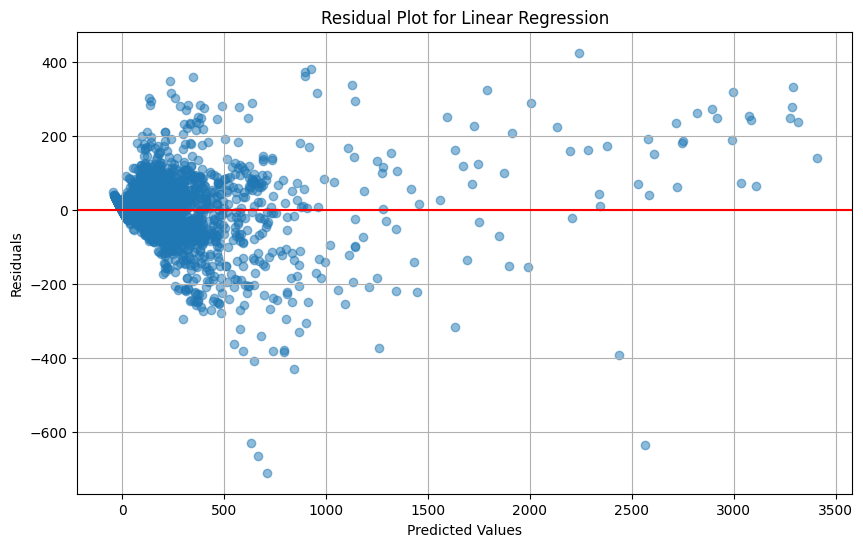

Linear Regression Mean Squared Error: 3986.0187
Linear Regression R-Squared: 0.9563
Cross-validated MSE for Linear Regression: 4423.0278 (+/- 679.8748)


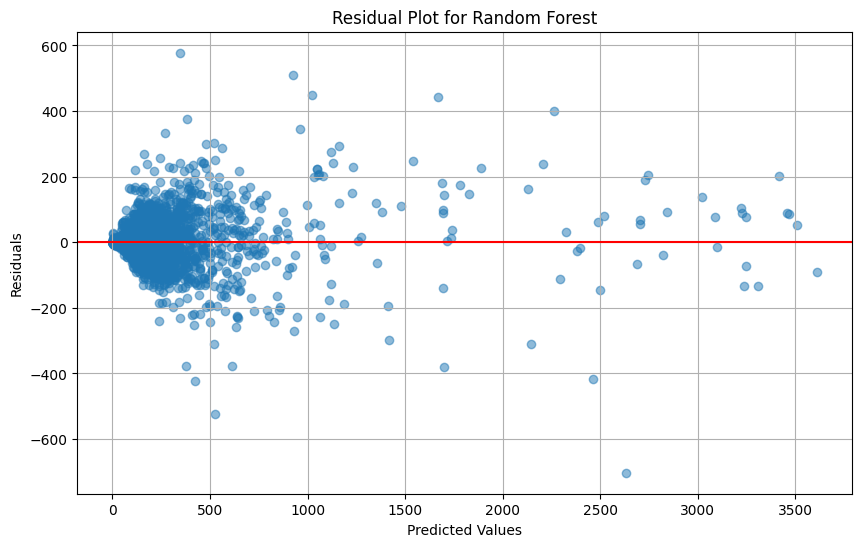

Random Forest Mean Squared Error: 2855.2310
Random Forest R-Squared: 0.9687
Cross-validated MSE for Random Forest: 3631.8321 (+/- 560.9967)


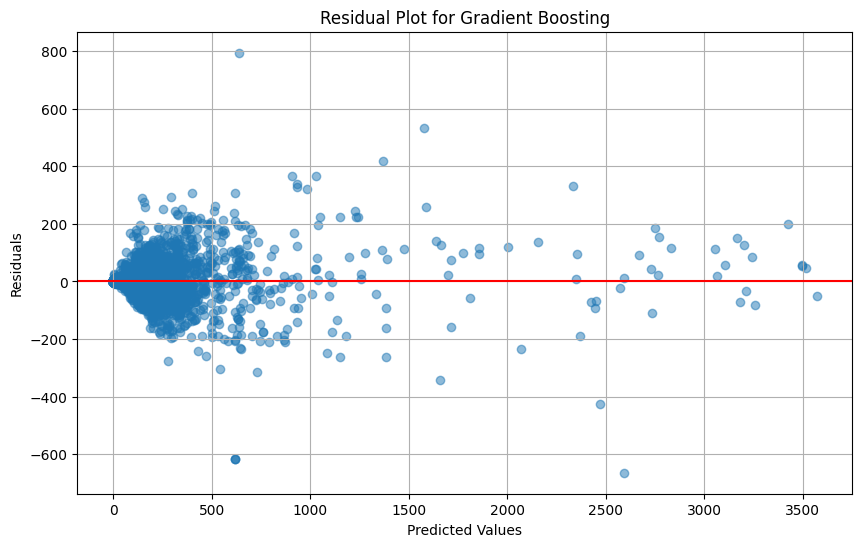

Gradient Boosting Mean Squared Error: 3100.7906
Gradient Boosting R-Squared: 0.9660
Cross-validated MSE for Gradient Boosting: 3607.8799 (+/- 525.5045)


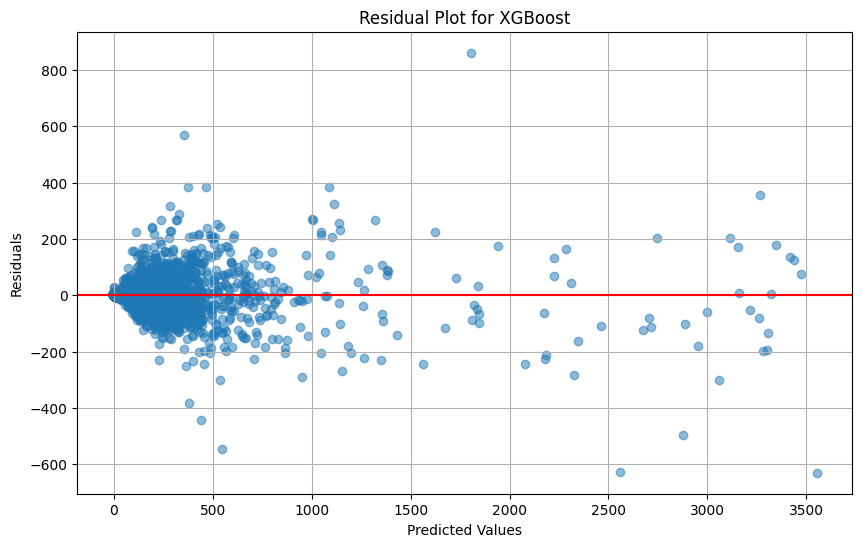

XGBoost Mean Squared Error: 2766.1157
XGBoost R-Squared: 0.9697
Cross-validated MSE for XGBoost: 3757.8478 (+/- 842.3664)


In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor


# Dictionary to store cross-validation results
cross_val_results = {}

for name, model in models.items():
    # Fit model and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Residual plot
    plot_residuals(y_test, y_pred, name)

    # MSE and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse:.4f}")
    print(f"{name} R-Squared: {r2:.4f}")

    # Cross-validate MSE
    mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cross_val_results[name] = mse_scores
    print(f"Cross-validated MSE for {name}: {mse_scores.mean():.4f} (+/- {mse_scores.std():.4f})")



Based on the residual plots and provided performance metrics (Mean Squared Error and R-Squared) for the four models, we can make the following comparisons:

1. XGBoost:
   - MSE: 2766.1157
   - R-Squared: 0.9697
   - Cross-Validated MSE: 3757.8478
   - The residual plot shows a somewhat uniform scatter around the zero line, but there's a slight pattern where residuals tend to be more negative as the predicted values increase. This could indicate that for larger predictions, XGBoost slightly overestimates the outcome.

2. Gradient Boosting:
   - MSE: 3100.7906
   - R-Squared: 0.9660
   - Cross-Validated MSE: 3607.8799
   - The residual plot for Gradient Boosting shows a denser cluster of residuals around zero, indicating good predictions for lower values. Similar to XGBoost, there's a slight pattern indicating potential overestimation for higher predicted values.

3. Random Forest:
   - MSE: 2855.2310
   - R-Squared: 0.9687
   - Cross-Validated MSE: 3631.8321
   - The Random Forest residuals are well-distributed across the range of predictions, with fewer large errors compared to Gradient Boosting and XGBoost, implying robust predictions across different values.

4. Linear Regression:
   - MSE: 3986.0187
   - R-Squared: 0.9563
   - Cross-Validated MSE: 4423.0278
   - The residuals are more spread out with a clear pattern indicating that predictions are not as consistent as with the ensemble models. There are noticeable deviations from zero, especially for lower predicted values, indicating potential underfitting.

Comparison Summary:
- Performance: XGBoost has the highest R-Squared value, suggesting it explains the variation in the data slightly better than the others. However, it has a higher cross-validated MSE than Random Forest, indicating potential overfitting.
- Overfitting: The cross-validated MSE for Random Forest is closer to its test MSE than that of XGBoost, which might suggest that Random Forest generalizes better to unseen data.
- Consistency: Random Forest and Gradient Boosting seem to have a more consistent performance across different prediction values compared to Linear Regression, which shows a tendency to underfit.
- Bias: The residual patterns suggest that ensemble methods might overestimate higher values to some extent, whereas Linear Regression might have bias issues across a range of predicted values.
- Model Selection: Despite the slightly higher MSE, Random Forest's performance is more stable across different metrics, making it a strong candidate. However, if the slightly better explanatory power of XGBoost (higher R-Squared) is critical, and one can manage the overfitting, XGBoost could be favored.

Opinion:
Given the high-stakes and complex nature of financial predictions, the slight differences in performance metrics might be crucial. The choice between Random Forest and XGBoost would likely come down to a trade-off between the slightly higher explanatory power of XGBoost and the slightly better generalization performance of Random Forest. In finance, where large transactions may hinge on predictive accuracy, the model with better generalization (Random Forest in this case) could be preferred. However, if the project can tolerate a bit more risk for potentially higher returns, and the additional variance is acceptable, XGBoost might be chosen for its slightly higher R-Squared. 

# Adding regularization to models to prevent overfitting

In [21]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Define models with regularization parameters
models = {
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4, min_samples_split=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=6, min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# Initialize dictionary to store results
results = {}

# Fit models, predict, and evaluate using cross-validation
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate MSE and R2 on the test set
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Perform cross-validation
    mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_mse = mse_scores.mean()
    std_mse = mse_scores.std()

    # Store results
    results[name] = {
        'Test MSE': mse,
        'Test R2': r2,
        'CV Mean MSE': mean_mse,
        'CV Std MSE': std_mse
    }

    print(f"{name} Test MSE: {mse:.4f}, Test R2: {r2:.4f}")
    print(f"{name} CV Mean MSE: {mean_mse:.4f}, CV Std MSE: {std_mse:.4f}")


Lasso Regression Test MSE: 4028.7117, Test R2: 0.9558
Lasso Regression CV Mean MSE: 4446.3172, CV Std MSE: 685.6303
Random Forest Test MSE: 2870.3158, Test R2: 0.9685
Random Forest CV Mean MSE: 3491.6630, CV Std MSE: 520.6075
Gradient Boosting Test MSE: 2710.4256, Test R2: 0.9703
Gradient Boosting CV Mean MSE: 3444.6932, CV Std MSE: 563.2054
XGBoost Test MSE: 3315.3837, Test R2: 0.9636
XGBoost CV Mean MSE: 3859.1506, CV Std MSE: 818.4956


Analysis of the performance of each model:

1. Lasso Regression:
   - Test MSE: 4028.7117 - The model, on average, is off by the square root of this value for each prediction on the test set.
   - Test R2: 0.9558 - The model explains approximately 95.58% of the variance in the target variable on the test set.
   - CV Mean MSE: 4446.3172 - On average, cross-validation indicates a slightly worse performance than the test set.
   - CV Std MSE: 685.6303 - The variation in MSE across the cross-validation folds. A higher standard deviation implies less reliable performance across different subsets of the data.

2. Random Forest*:
   - Test MSE: 2870.3158 - Shows a better fit compared to Lasso, indicating that on average, the errors in the predictions are lower.
   - Test R2: 0.9685 - Suggests that the model explains around 96.85% of the variability in the test set, which is better than Lasso Regression.
   - CV Mean MSE: 3491.6630 - Cross-validation suggests robust generalization, with better performance than Lasso Regression.
   - CV Std MSE: 520.6075 - Less variability in performance across folds than Lasso, indicating more reliable performance.

3. Gradient Boosting:
   - Test MSE: 2710.4256 - The lowest test MSE among all models, suggesting the best fit to the test set.
   - Test R2: 0.9703 - Indicates the highest percentage of variance explained in the test set among all models.
   - CV Mean MSE: 3444.6932 - Similar to Random Forest, it indicates good generalization.
   - CV Std MSE: 563.2054 - A bit higher than Random Forest, suggesting slightly less consistent performance across different folds.

4. XGBoost:
   - Test MSE: 3315.3837 - The errors are higher on the test set compared to Random Forest and Gradient Boosting.
   - Test R2: 0.9636 - It explains around 96.36% of the variance, which is slightly less than Random Forest and Gradient Boosting.
   - CV Mean MSE: 3859.1506 - Shows that the model's generalization is not as good as the other two ensemble models.
   - CV Std MSE: 818.4956 - The highest variability across folds, indicating less reliable performance.

Summary:
Gradient Boosting seems to have the best performance on the test set, achieving the lowest MSE and the highest R2, indicating the highest accuracy and variability explained. However, its cross-validation results are slightly worse than the Random Forest, which could mean that Random Forest might be more robust to different subsets of the data.

Random Forest demonstrates a strong balance between test performance and reliability across different datasets, as shown by its low cross-validation mean MSE and standard deviation.

Lasso Regression, despite being the simplest model, shows decent performance on the test set but is outperformed by the ensemble methods. Its cross-validation results also indicate that it might not generalize as well as the others.

XGBoost does not perform as well as Gradient Boosting or Random Forest in this case. While still a powerful model, it might require further tuning of hyperparameters to improve its performance.

# Validation Curves
This code cell below is executing a model validation process using different regression models to determine the optimal hyperparameters for each. It performs the following steps:

1. Lasso Regression Validation Curve:
   - It uses validation_curve to evaluate the Lasso regression model over a range of alpha values (which control the strength of regularization). The goal is to find the alpha value that minimizes the Mean Squared Error (MSE).
   - A plot is then generated to visualize the training and validation errors across different alpha values. The shaded areas represent the variability (one standard deviation from the mean) of the training and validation scores.
   - Ideally, you want to find the value of alpha where the validation error is lowest, and the training error is reasonably low, indicating a well-generalized model.

2. Random Forest Validation Curve:
   - Similar to Lasso, but the hyperparameter here is max_depth, which controls the depth of each tree in the ensemble.
   - The plot shows how the training and validation errors change as the tree depth increases. If the validation error increases with depth while training error decreases, it may suggest overfitting.

3. Gradient Boosting Validation Curve:
   - Again, the max_depth parameter is evaluated for Gradient Boosting, which affects the depth of the individual regression trees in the model.
   - The plot allows for a comparison of training versus validation error to find the depth that provides a good balance between bias and variance.

4. XGBoost Validation Curve:
   - The same approach is applied to XGBoost, an optimized gradient boosting library, where max_depth is varied.
   - The goal is to select the depth that minimizes validation error without overfitting, as shown by the plotted validation curve.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.602e+07, tolerance: 1.386e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.592e+07, tolerance: 1.386e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

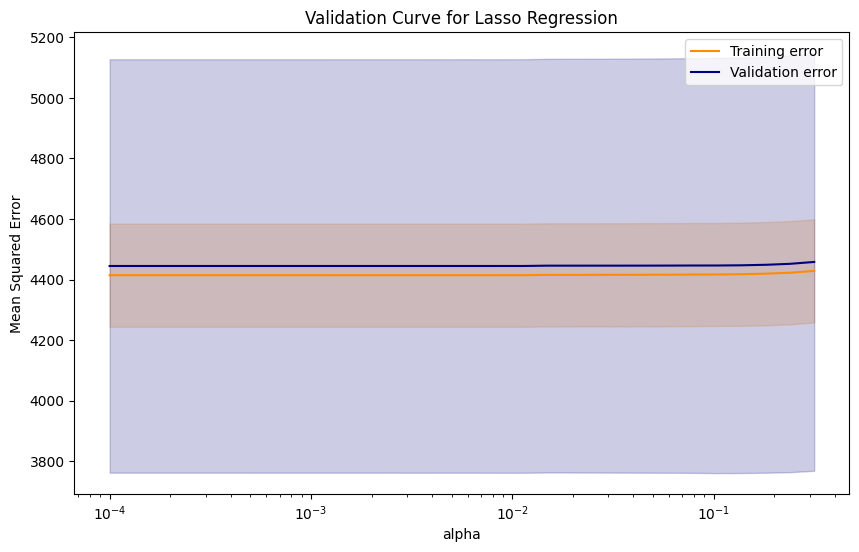

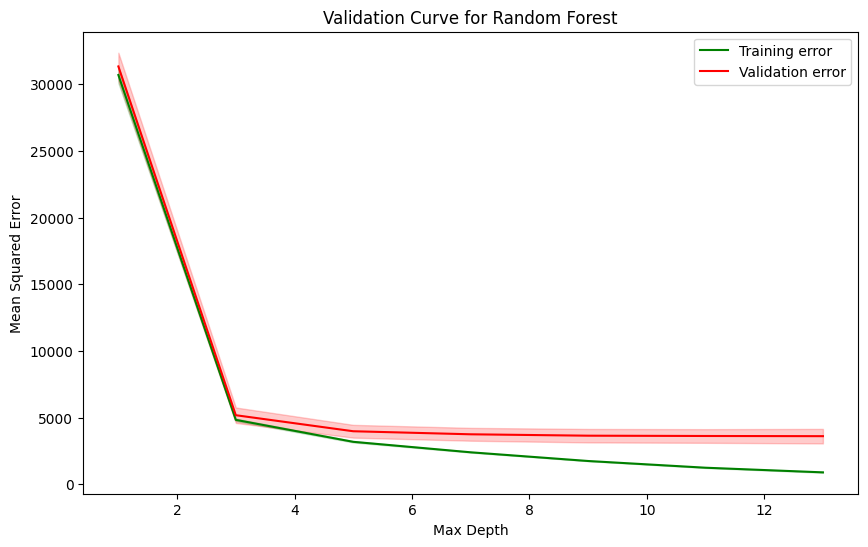

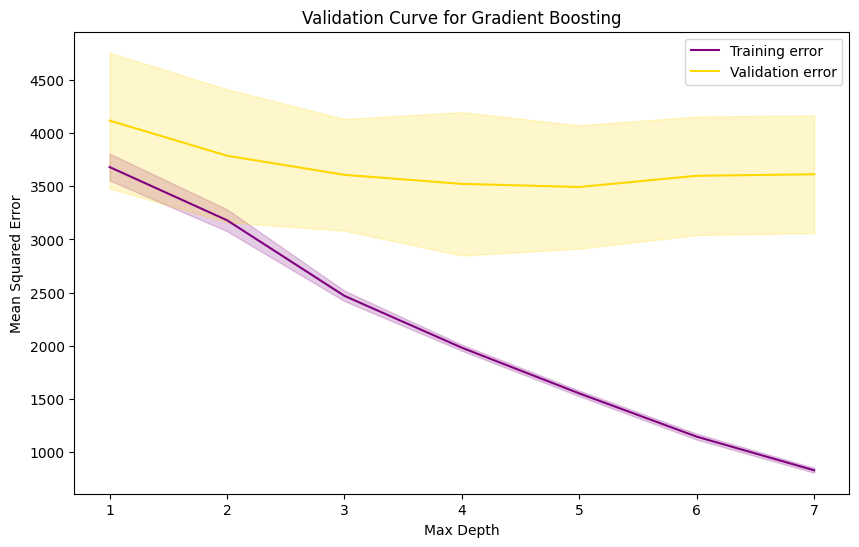

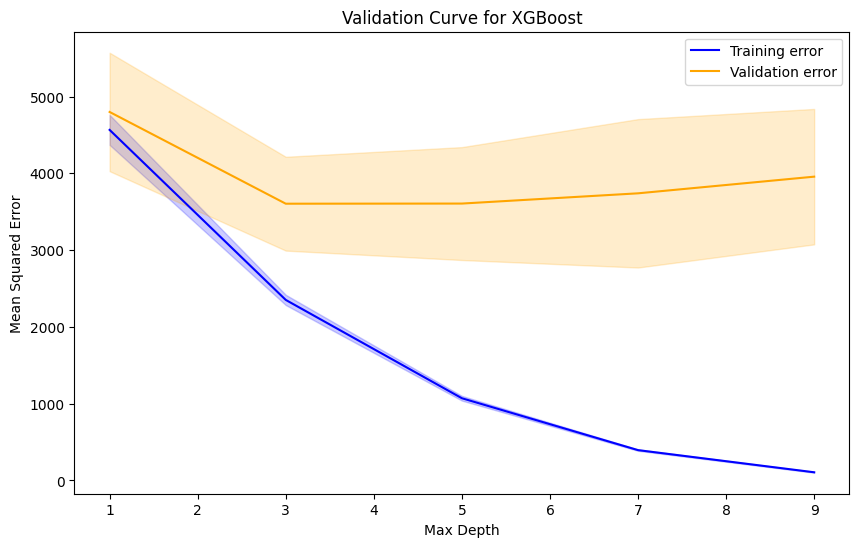

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import validation_curve, GridSearchCV
from xgboost import XGBRegressor


# 1. Lasso Regression
alpha_range = np.logspace(-4, -0.5, 30)
train_scores, valid_scores = validation_curve(
    Lasso(random_state=42), X_train_scaled, y_train, 
    param_name="alpha", param_range=alpha_range,
    cv=5, scoring='neg_mean_squared_error'
)

# Plot Lasso
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_range, -np.mean(train_scores, axis=1), label="Training error", color="darkorange")
plt.semilogx(alpha_range, -np.mean(valid_scores, axis=1), label="Validation error", color="navy")
plt.fill_between(alpha_range, -np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 -np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), color="darkorange", alpha=0.2)
plt.fill_between(alpha_range, -np.mean(valid_scores, axis=1) - np.std(valid_scores, axis=1),
                 -np.mean(valid_scores, axis=1) + np.std(valid_scores, axis=1), color="navy", alpha=0.2)
plt.title("Validation Curve for Lasso Regression")
plt.xlabel("alpha")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

# 2. Random Forest
depth_range = np.arange(1, 15, 2)
train_scores, valid_scores = validation_curve(
    RandomForestRegressor(n_estimators=100, random_state=42), X_train_scaled, y_train, 
    param_name="max_depth", param_range=depth_range,
    cv=5, scoring='neg_mean_squared_error'
)

# Plot Random Forest
plt.figure(figsize=(10, 6))
plt.plot(depth_range, -np.mean(train_scores, axis=1), label="Training error", color="green")
plt.plot(depth_range, -np.mean(valid_scores, axis=1), label="Validation error", color="red")
plt.fill_between(depth_range, -np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 -np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), color="green", alpha=0.2)
plt.fill_between(depth_range, -np.mean(valid_scores, axis=1) - np.std(valid_scores, axis=1),
                 -np.mean(valid_scores, axis=1) + np.std(valid_scores, axis=1), color="red", alpha=0.2)
plt.title("Validation Curve for Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

# 3. Gradient Boosting
depth_range = np.arange(1, 8, 1)
train_scores, valid_scores = validation_curve(
    GradientBoostingRegressor(n_estimators=100, random_state=42), X_train_scaled, y_train, 
    param_name="max_depth", param_range=depth_range,
    cv=5, scoring='neg_mean_squared_error'
)

# Plot Gradient Boosting
plt.figure(figsize=(10, 6))
plt.plot(depth_range, -np.mean(train_scores, axis=1), label="Training error", color="purple")
plt.plot(depth_range, -np.mean(valid_scores, axis=1), label="Validation error", color="gold")
plt.fill_between(depth_range, -np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 -np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), color="purple", alpha=0.2)
plt.fill_between(depth_range, -np.mean(valid_scores, axis=1) - np.std(valid_scores, axis=1),
                 -np.mean(valid_scores, axis=1) + np.std(valid_scores, axis=1), color="gold", alpha=0.2)
plt.title("Validation Curve for Gradient Boosting")
plt.xlabel("Max Depth")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

# 4. XGBoost
depth_range = np.arange(1, 10, 2)
train_scores, valid_scores = validation_curve(
    XGBRegressor(n_estimators=100, random_state=42), X_train_scaled, y_train, 
    param_name="max_depth", param_range=depth_range,
    cv=5, scoring='neg_mean_squared_error'
)

# Plot XGBoost
plt.figure(figsize=(10, 6))
plt.plot(depth_range, -np.mean(train_scores, axis=1), label="Training error", color="blue")
plt.plot(depth_range, -np.mean(valid_scores, axis=1), label="Validation error", color="orange")
plt.fill_between(depth_range, -np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 -np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), color="blue", alpha=0.2)
plt.fill_between(depth_range, -np.mean(valid_scores, axis=1) - np.std(valid_scores, axis=1),
                 -np.mean(valid_scores, axis=1) + np.std(valid_scores, axis=1), color="orange", alpha=0.2)
plt.title("Validation Curve for XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

1. Lasso Regression Validation Curve:
   - The plot shows that both training and validation errors are relatively flat across the range of alpha values.
   - This indicates that the impact of the regularization strength is not significant on the model's performance for the given data, suggesting that the model is not overly sensitive to the alpha parameter within this range.
   - There's a narrow band between training and validation errors, implying good generalization.

2. Random Forest Validation Curve:
   - The training error starts high and decreases sharply as max_depth increases, then plateaus, suggesting that deeper trees better capture the training data.
   - The validation error mirrors this trend initially but starts increasing slightly after a depth of 6, which might be a sign of overfitting.
   - The optimal max_depth appears to be around 6, as it is the point before the validation error starts increasing.

3. Gradient Boosting Validation Curve:
   - Shows a decreasing trend in both training and validation errors as the max_depth increases.
   - The validation error is higher than the training error but converges as depth increases, which is typical for gradient boosting models as they can handle more complexity without overfitting.
   - There seems to be a good balance between bias and variance at a max_depth between 4 and 5.

4. XGBoost Validation Curve:
   - There is a consistent decrease in training error with increasing max_depth, while the validation error decreases initially but starts to plateau.
   - The optimal point seems to be around a depth of 5 to 7 where the validation error is minimized.

Interpretation:
   - The Lasso plot suggests a well-generalized model across the alpha parameter range.
   - Random Forest and Gradient Boosting both show an optimal depth where the model generalizes well without overfitting.
   - XGBoost demonstrates a stronger decline in error with depth, possibly due to the model's advanced regularization techniques, but there's an indication of potential overfitting beyond a max_depth of 7.
   - Across all models, the common goal is to find the hyperparameter value that minimizes validation error while maintaining a small gap between training and validation error. This gap represents the model's ability to generalize to unseen data.

# Performing Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV

# Taking RandomForestRegressor as the best performing based on validation curves
param_grid = {
    'max_depth': [6, 8, 10],  # Range around the previously identified good value
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200]  # More estimators might improve performance
}

# Initialize the GridSearchCV object
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search and fit the model
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on the test set (X_test_scaled, y_test need to be defined)
from sklearn.metrics import mean_squared_error, r2_score

y_pred = best_model.predict(X_test_scaled)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"Final Model MSE: {final_mse}")
print(f"Final Model R2: {final_r2}")

Final Model MSE: 2868.487795234084
Final Model R2: 0.9685476382452812


The code cell above describes the process of hyperparameter tuning for a RandomForestRegressor model using GridSearchCV, a systematic approach to parameter tuning that methodically builds and evaluates a model for each combination of algorithm parameters specified in a grid.

Here’s a breakdown of what’s happening:

1. Parameter Grid Setup: A dictionary named param_grid is defined, which contains several lists of parameters to try with the RandomForestRegressor. The grid includes different values for max_depth, min_samples_split, min_samples_leaf, and n_estimators. These parameters are key to preventing overfitting (max_depth, min_samples_split, min_samples_leaf) and improving the model's ability to learn from the data (n_estimators).

2. GridSearchCV Initialization: GridSearchCV is initialized with the RandomForestRegressor as the estimator, the parameter grid, a cross-validation generator (cv=5), and the scoring method (neg_mean_squared_error). The n_jobs=-1 argument tells the process to use all available CPU cores to perform the cross-validated grid search in parallel, speeding up the computation.

3. Model Fitting: GridSearchCV conducts the grid search on the scaled training data (X_train_scaled, y_train) to find the best combination of parameters based on the negative mean squared error.

4. Best Model Selection: After the grid search, the best combination of parameters (best_params) and the best model (best_estimator_) are selected based on the performance during cross-validation.

5. Model Evaluation: The best model is then evaluated on the scaled test data (X_test_scaled, y_test) to calculate the Mean Squared Error (MSE) and the coefficient of determination (R^2 score), which are common metrics for regression analysis.

6. Results: The final MSE of the best model is approximately 2868.49, and the final R^2 score is about 0.9685. This suggests that the model is able to explain around 96.85% of the variance in the test data, which is a high level of predictive accuracy.

The output tells us that the final model, after grid search, has a very good fit to the test data. It means that the RandomForestRegressor model with the identified hyperparameters is likely to be robust and reliable for predicting outcomes based on the features in the training set, and it can be considered for deployment or further refinement if needed. This process of tuning and validation is critical in developing machine learning models that are both accurate and generalizable.

# Trying Random Search
In the below code cell, we're utilizing RandomizedSearchCV, which is different from GridSearchCV in that it doesn't try out all possible combinations but rather selects a random sample of combinations. It's typically faster and more practical when the hyperparameter space is large. We used this because the output of the GridSearch was not better than our previous model so we wanted to try random search to maybe find a model which is better.

Here's the breakdown of the code steps:

1. Parameter Distribution Definition: A parameter distribution dictionary (param_dist) is defined, where you have ranges for max_depth, min_samples_split, min_samples_leaf, and n_estimators. These are not lists of values but distributions from which RandomizedSearchCV will sample.

2. RandomizedSearchCV Initialization: RandomizedSearchCV is initialized with the RandomForestRegressor as the base model and param_dist as the distribution of parameters to sample from. It's set to sample n_iter_search times (in this case, 20 iterations), using 5-fold cross-validation, and to optimize the negative mean squared error.

3. Model Fitting: The random search object (random_search) fits the model to the scaled training data (X_train_scaled, y_train) to find the best hyperparameters in the specified random search.

4. Best Model and Parameters Retrieval: After random search, the best hyperparameters (best_params) and model (best_estimator_) are retrieved.

5. Model Evaluation: The best model from the random search is evaluated on the scaled test data (X_test_scaled, y_test). The final MSE and R^2 score are calculated to assess the model's performance.

6. Results Output: The performance of the best model from the random search is printed out. The Random Search Best Model MSE and Random Search Best Model R2 indicate how well the model with the best-found parameters predicts the test data.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Define the parameter distribution
param_dist = {
    'max_depth': sp_randint(3, 20),  # Or any other range you deem suitable
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'n_estimators': sp_randint(100, 500),  # More estimators might improve performance
    # Add more parameters here if you like
}

# Initialize the RandomizedSearchCV object
rf = RandomForestRegressor(random_state=42)
n_iter_search = 20  # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)

# Perform the random search and fit the model
random_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test_scaled)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"Random Search Best Model MSE: {final_mse}")
print(f"Random Search Best Model R2: {final_r2}")

# If this performance is satisfactory, this model is your final model.


Random Search Best Model MSE: 2845.9768789888967
Random Search Best Model R2: 0.9687944656790078


The output from the RandomizedSearchCV suggests that the best model it found has a Mean Squared Error (MSE) of approximately 2845.98 and an R-squared (R^2) value of about 0.9688. Which is now our best model.
The MSE is good according to the scale of our model.

Now that we can predict C_Last ( the last price at which the option can end up), we can use a formula (C_Last - C_Bid / C_Bid) * 100 which would give us a estimate of the percentage profit we can make.

 This can be used as a very good staarting point for making informed decisions on whether or not a call option is worth buying or not.